<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/WISDM_CBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Multiply

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report


# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [3]:


from google.colab import drive

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/AI_study/WISDM_ar_v1.1_raw.txt",
                 header=None,
                 sep=',',
                 names=['user', 'activity', 'timestamp', 'x', 'y', 'z'],
                 on_bad_lines='skip')

Mounted at /content/drive


In [4]:

df['z'] = df['z'].astype(str).str.replace(';', '').str.strip()

# 결측값 제거
df = df.dropna()

print(f"데이터 로딩 완료: {df.shape}")
df.head()

데이터 로딩 완료: (1086466, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df


,user,activity,timestamp,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.50395286
1,33,1,49106062271000,5.012288,11.264028,0.95342433
2,33,1,49106112167000,4.903325,10.882658,-0.08172209
3,33,1,49106222305000,-0.612916,18.496431,3.0237172
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,2,131623331483000,9.000000,-1.570000,1.69
1086462,19,2,131623371431000,9.040000,-1.460000,1.73
1086463,19,2,131623411592000,9.080000,-1.380000,1.69
1086464,19,2,131623491487000,9.000000,-1.460000,1.73


In [7]:

df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [8]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 2832]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

# NaN 값 제거
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()


print("======데이터 분할(사용자 기반)=====")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")


======데이터 분할(사용자 기반)=====
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 36명, 데이터 수: 1086465
테스트용 사용자 수: 4명, 데이터 수: 120055


In [10]:


# Define the features to be scaled
features = ['x', 'y', 'z']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform all dataframes
scaler.fit(train_df[features])        # 훈련 데이터로만 학습
train_df[features] = scaler.transform(train_df[features])  # 동일 기준 적용
val_df[features] = scaler.transform(val_df[features])      # 동일 기준 적용
test_df[features] = scaler.transform(test_df[features])    # 동일 기준 적용

print("데이터 스케일링 완료")

데이터 스케일링 완료


In [11]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [12]:

TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [13]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [24]:
#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

# x_train = x_train / np.max(np.abs(x_train)) # 이 부분 제거
# x_val = x_val / np.max(np.abs(x_val)) # 이 부분 제거

# Reshape data for Conv2D
x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, x_train.shape[2], 1)
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, x_val.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, x_test.shape[2], 1)


print("훈련 데이터:", x_train.shape, y_train_hot.shape)
print("검증 데이터", x_val.shape, y_val_hot.shape)

print("====================================")

x_train.shape, x_val.shape

훈련 데이터: (20575, 80, 3, 1) (20575, 6)
검증 데이터 (27160, 80, 3, 1) (27160, 6)


((20575, 80, 3, 1), (27160, 80, 3, 1))

### CBAM

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Multiply, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Add, Activation, Concatenate, Conv2D, BatchNormalization # Import necessary layers


import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate # Keep this import
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report


# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D, GlobalAveragePooling2D, multiply, Activation, Concatenate, GlobalMaxPooling2D # Add missing layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


def channel_attention(input_feature, ratio=8):
    """
    CBAM의 채널 어텐션 모듈

    Args:
        input_feature: 입력 특성맵
        ratio: 채널 축소 비율 (기본값: 8)

    Returns:
        채널 어텐션이 적용된 특성맵
    """
    channel_axis = -1
    channel = input_feature.shape[channel_axis]

    # 공유 MLP 레이어 정의
    shared_layer_one = Dense(
        channel // ratio,
        activation='relu',
        kernel_initializer='he_normal',
        use_bias=False
    )
    shared_layer_two = Dense(
        channel,
        kernel_initializer='he_normal',
        use_bias=False
    )

    # Global Average Pooling 경로
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    # Global Max Pooling 경로
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    # 두 경로의 결과를 합산하고 sigmoid로 채널 가중치 생성
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # 원본 특성맵에 채널 가중치 적용
    return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature, kernel_size=7):
    """
    CBAM의 공간 어텐션 모듈

    Args:
        input_feature: 입력 특성맵
        kernel_size: 컨볼루션 커널 크기 (기본값: 7)

    Returns:
        공간 어텐션이 적용된 특성맵
    """
    channel_axis = -1

    # 채널 축에 대해 Average와 Max pooling 수행
    avg_pool = tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.mean(x, axis=channel_axis, keepdims=True)
    )(input_feature)

    max_pool = tf.keras.layers.Lambda(
        lambda x: tf.keras.backend.max(x, axis=channel_axis, keepdims=True)
    )(input_feature)

    # 두 풀링 결과를 결합
    concat = Concatenate(axis=channel_axis)([avg_pool, max_pool])

    # 컨볼루션과 시그모이드로 공간 가중치 생성
    cbam_feature = Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=1,
        padding='same',
        activation='sigmoid',
        kernel_initializer='he_normal',
        use_bias=False
    )(concat)

    # 원본 특성맵에 공간 가중치 적용
    return multiply([input_feature, cbam_feature])


def cbam_block(input_feature, ratio=8):
    """
    CBAM 블록: 채널 어텐션과 공간 어텐션을 순차적으로 적용

    Args:
        input_feature: 입력 특성맵
        ratio: 채널 어텐션의 축소 비율

    Returns:
        CBAM이 적용된 특성맵
    """
    # 채널 어텐션 먼저 적용
    cbam_feature = channel_attention(input_feature, ratio)
    # 공간 어텐션 적용
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def create_cbam_model(input_shape, num_classes, dropout_rate=0.4):
    """
    CBAM이 적용된 CNN 모델 생성

    Args:
        input_shape: 입력 데이터의 형태 (height, width, channels)
        num_classes: 분류할 클래스 수
        dropout_rate: 드롭아웃 비율 (기본값: 0.4)

    Returns:
        컴파일되지 않은 Keras 모델
    """
    inputs = Input(shape=input_shape)

    # 첫 번째 컨볼루션 블록
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # CBAM 블록 적용
    x = cbam_block(x, ratio=8)

    # 두 번째 컨볼루션 블록
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # 분류기
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 80, 3, 64) │        640 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 64) │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 80, 3, 64) │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 64) │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 8)   │        512 │ reshape_2[0][0],  │
│                     │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 64)  │        512 │ dense_3[0][0],    │
│                     │                   │            │ dense_3[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1, 64)  │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_4[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1, 1, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 80, 3, 64) │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 80, 3, 1)  │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 80, 3, 1)  │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 80, 3, 2)  │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 80, 3, 1)  │         98 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 80, 3, 64) │          0 │ multiply_2[0][0], │
│ (Multiply)          │                   │            │ conv2d_10[0][0] 

 Total params: 262,440 (1.00 MB)

 Trainable params: 261,672 (1022.16 KB)

 Non-trainable params: 768 (3.00 KB)

CBAM 모델이 성공적으로 생성되었습니다!


In [ ]:
def compile_cbam_model(model, learning_rate=0.001):
    """
    CBAM 모델을 컴파일

    Args:
        model: 컴파일할 모델
        learning_rate: 학습률 (기본값: 0.001)

    Returns:
        컴파일된 모델
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define the input shape and number of classes based on your data
input_shape = x_train.shape[1:]  # Use the shape of your training data
num_classes = y_train_hot.shape[1] # Use the number of classes from your one-hot encoded labels

# Create the model
model = create_cbam_model(input_shape, num_classes)

# Compile the model
model = compile_cbam_model(model)

# Model summary
model.summary()

print("CBAM 모델이 성공적으로 생성되었습니다!")

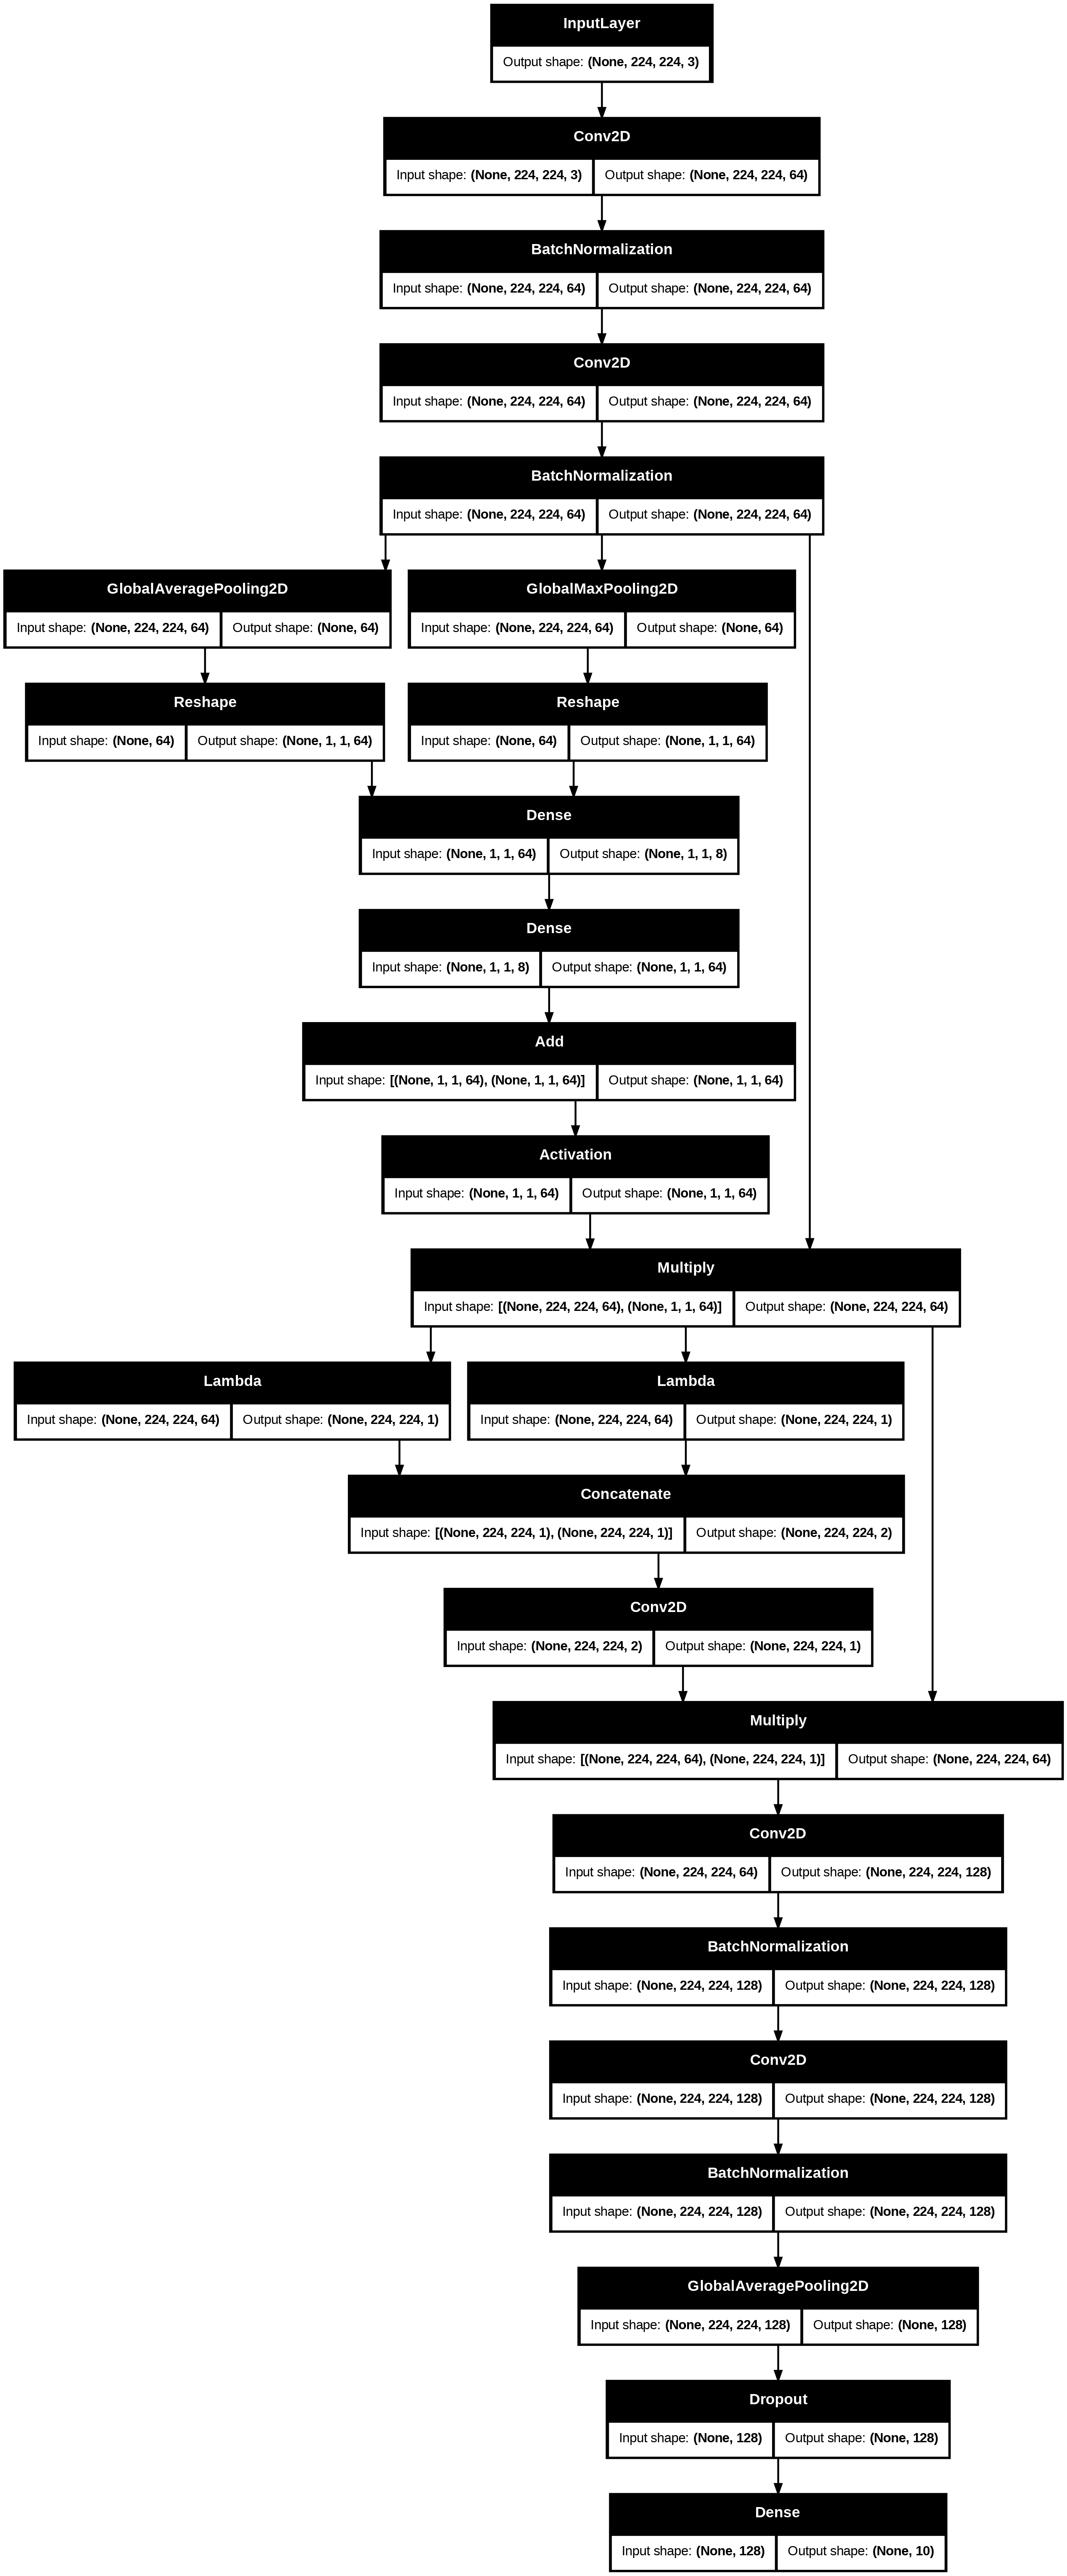

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history = model.fit(x_train, y_train_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val_hot),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.8504 - loss: 0.4332 - val_accuracy: 0.9102 - val_loss: 0.2682 - learning_rate: 0.0010
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9359 - loss: 0.1857 - val_accuracy: 0.9313 - val_loss: 0.2027 - learning_rate: 0.0010
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9570 - loss: 0.1262 - val_accuracy: 0.9424 - val_loss: 0.1820 - learning_rate: 0.0010
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9620 - loss: 0.1117 - val_accuracy: 0.9329 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9671 - loss: 0.1004 - val_accuracy: 0.9455 - val_loss: 0.1803 - learning_rate: 0.0010
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9730 - loss: 0.0829 - val_accuracy: 0.9363 - val_loss: 0.2210 - learning_rate: 0.0010
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9744 - loss:

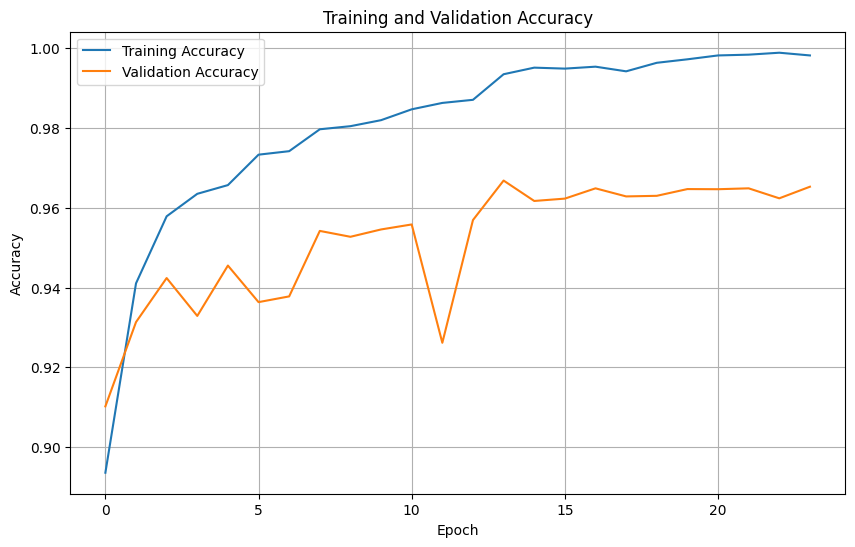

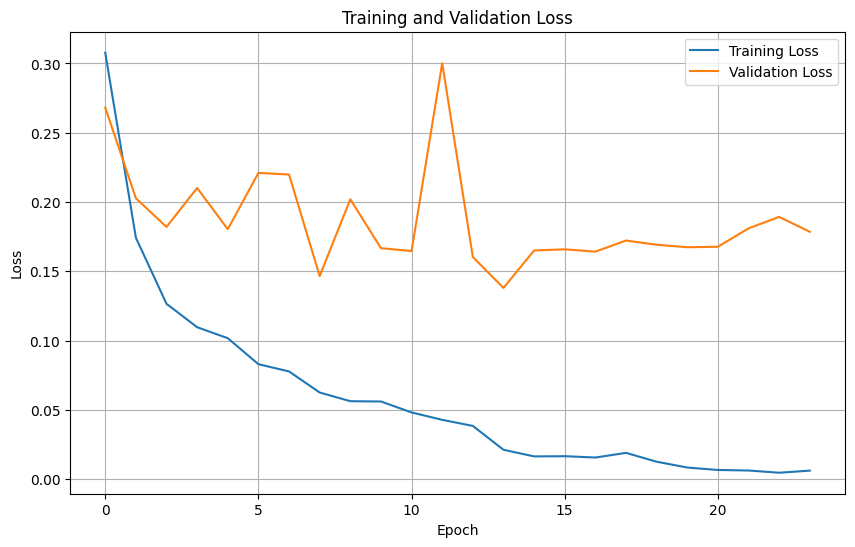

In [31]:
# 정확도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


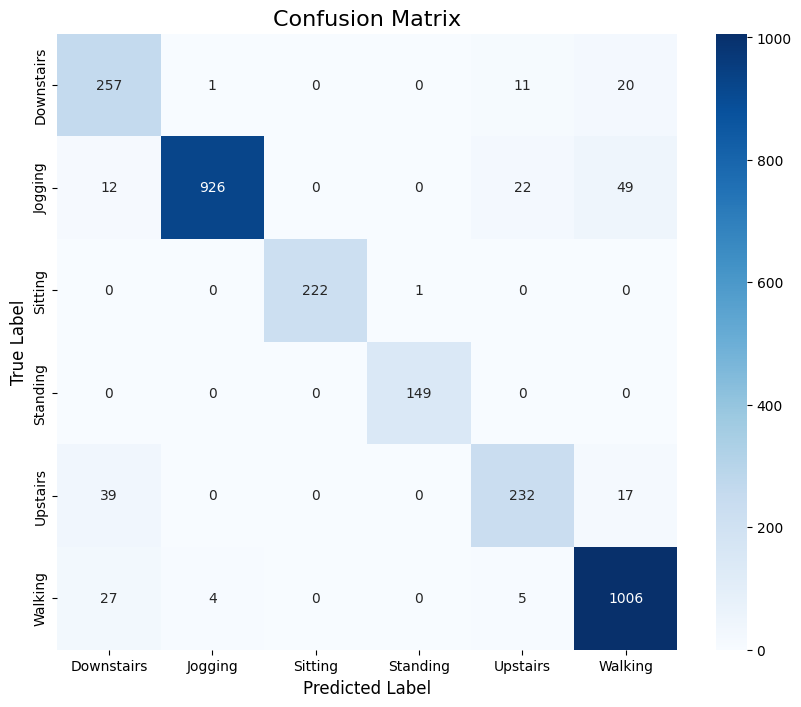

In [27]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_test is a 1D array if it's not already
y_test = np.array(y_test).flatten()

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [28]:
loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.9307
테스트 데이터 손실 (Loss): 0.4247


In [29]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n===== 분류 리포트 =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

===== 분류 리포트 =====
              precision    recall  f1-score   support

  Downstairs       0.77      0.89      0.82       289
     Jogging       0.99      0.92      0.95      1009
     Sitting       1.00      1.00      1.00       223
    Standing       0.99      1.00      1.00       149
    Upstairs       0.86      0.81      0.83       288
     Walking       0.92      0.97      0.94      1042

    accuracy                           0.93      3000
   macro avg       0.92      0.93      0.92      3000
weighted avg       0.93      0.93      0.93      3000

